# K2 Market Data Platform - Demo Notebook

**K2 Platform** is a distributed market data processing platform designed for high-frequency trading environments.

This notebook demonstrates:
- Platform architecture and data flow
- Sample data exploration (ASX trades)
- Data ingestion pipeline
- Query engine capabilities
- Time-travel queries with Iceberg
- REST API usage

**Prerequisites**:
- Docker services running (`make docker-up`)
- Infrastructure initialized (`make init-infra`)

## 1. Architecture Overview

```
┌─────────────────────────────────────────────────────────────────────┐
│                       K2 Platform Architecture                      │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  CSV Files → Kafka (Avro) → Iceberg → DuckDB → REST API             │
│                                                                     │
│  • CSV batch ingestion with schema validation                       │
│  • Kafka streaming with at-least-once delivery                      │
│  • Iceberg ACID transactions with time-travel                       │
│  • DuckDB sub-second analytical queries                             │
│  • FastAPI REST endpoints with OpenAPI docs                         │
│                                                                     │
│  Key Technologies:                                                  │
│  • Apache Kafka + Schema Registry                                   │
│  • Apache Iceberg (table format)                                    │
│  • DuckDB (embedded analytics)                                      │
│  • FastAPI + Prometheus + Grafana                                   │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

## 2. Setup & Imports

In [1]:
# Standard library
import sys
from datetime import datetime
from pathlib import Path

import matplotlib.dates as mdates

# Visualization
import matplotlib.pyplot as plt

# Data processing
import pandas as pd

# Add src to path for k2 imports
sys.path.insert(0, str(Path.cwd().parent / "src"))

# Display settings
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 150)
plt.style.use('seaborn-v0_8-whitegrid')

print("Imports loaded successfully!")

Imports loaded successfully!


In [2]:
# Configuration
SAMPLE_DATA_DIR = Path.cwd().parent / "data" / "sample"
TRADES_DIR = SAMPLE_DATA_DIR / "trades"
QUOTES_DIR = SAMPLE_DATA_DIR / "quotes"

# Company ID to Symbol mapping
COMPANY_MAPPING = {
    "7181": {"symbol": "DVN", "name": "Devine Ltd"},
    "3153": {"symbol": "MWR", "name": "MGM Wireless"},
    "7078": {"symbol": "BHP", "name": "BHP Billiton"},
    "7458": {"symbol": "RIO", "name": "Rio Tinto"},
}

# Verify sample data exists
if SAMPLE_DATA_DIR.exists():
    print(f"Sample data directory: {SAMPLE_DATA_DIR}")
    print(f"Available trade files: {list(TRADES_DIR.glob('*.csv'))}")
else:
    print("Warning: Sample data not found!")

Sample data directory: /Users/rjdscott/Documents/code/demos/k2-market-data-platform/data/sample
Available trade files: [PosixPath('/Users/rjdscott/Documents/code/demos/k2-market-data-platform/data/sample/trades/7458.csv'), PosixPath('/Users/rjdscott/Documents/code/demos/k2-market-data-platform/data/sample/trades/7181.csv'), PosixPath('/Users/rjdscott/Documents/code/demos/k2-market-data-platform/data/sample/trades/7078.csv'), PosixPath('/Users/rjdscott/Documents/code/demos/k2-market-data-platform/data/sample/trades/3153.csv')]


## 3. Sample Data Exploration

The sample data contains real ASX (Australian Securities Exchange) market data from March 10-14, 2014.

| Symbol | Company | Trades | Notes |
|--------|---------|--------|-------|
| DVN | Devine Ltd | 231 | Low volume, good for demos |
| MWR | MGM Wireless | 10 | Very low volume |
| BHP | BHP Billiton | 91,630 | High volume mining stock |
| RIO | Rio Tinto | 108,670 | High volume mining stock |

In [3]:
# Load DVN trades (small dataset for demo)
dvn_file = TRADES_DIR / "7181.csv"

# Sample data has no header, so we specify column names
df_dvn = pd.read_csv(
    dvn_file,
    names=["Date", "Time", "Price", "Volume", "Qualifiers", "Venue", "BuyerID"],
)

print(f"DVN Trades: {len(df_dvn)} records")
print(f"Date range: {df_dvn['Date'].iloc[0]} to {df_dvn['Date'].iloc[-1]}")
print("\nFirst 10 trades:")
df_dvn.head(10)

DVN Trades: 232 records
Date range: 03/10/2014 to 03/14/2014

First 10 trades:


,Date,Time,Price,Volume,Qualifiers,Venue,BuyerID
0,03/10/2014,10:13:34.553,0.670,8216,0,NaN,NaN
1,03/10/2014,10:13:34.553,0.670,784,2,NaN,NaN
2,03/10/2014,10:21:23.977,0.670,3000,0,NaN,NaN
3,03/10/2014,11:16:11.355,0.670,1469,0,NaN,NaN
4,03/10/2014,11:29:15.863,0.675,120,0,NaN,NaN
5,03/10/2014,11:49:51.279,0.675,14000,0,NaN,NaN
6,03/10/2014,12:00:08.830,0.675,100,0,NaN,NaN
7,03/10/2014,12:15:08.408,0.675,100,0,NaN,NaN
8,03/10/2014,14:13:19.874,0.680,1827,0,NaN,NaN
9,03/10/2014,14:13:19.874,0.690,4108,0,NaN,NaN


In [4]:
# Data statistics
print("=== DVN Trade Statistics ===")
print(f"\nPrice Range: ${df_dvn['Price'].min():.2f} - ${df_dvn['Price'].max():.2f}")
print(f"Average Price: ${df_dvn['Price'].mean():.2f}")
print(f"Total Volume: {df_dvn['Volume'].sum():,}")
print(f"Average Trade Size: {df_dvn['Volume'].mean():,.0f}")
print(f"\nVenues: {df_dvn['Venue'].unique().tolist()}")
print(f"Qualifiers: {df_dvn['Qualifiers'].unique().tolist()}")

=== DVN Trade Statistics ===

Price Range: $0.62 - $0.69
Average Price: $0.65
Total Volume: 449,097
Average Trade Size: 1,936

Venues: [nan]
Qualifiers: [0, 2, 25]


In [5]:
# Parse timestamps for time-series analysis
def parse_timestamp(row):
    """Parse sample data timestamp format to datetime."""
    dt_str = f"{row['Date']} {row['Time']}"
    try:
        return datetime.strptime(dt_str, "%m/%d/%Y %H:%M:%S.%f")
    except ValueError:
        return datetime.strptime(dt_str, "%m/%d/%Y %H:%M:%S")

df_dvn['Timestamp'] = df_dvn.apply(parse_timestamp, axis=1)
df_dvn['DateParsed'] = pd.to_datetime(df_dvn['Date'], format='%m/%d/%Y')

print("Timestamps parsed successfully!")
df_dvn[['Date', 'Time', 'Timestamp', 'Price', 'Volume']].head()

Timestamps parsed successfully!


,Date,Time,Timestamp,Price,Volume
0,03/10/2014,10:13:34.553,2014-03-10 10:13:34.553,0.670,8216
1,03/10/2014,10:13:34.553,2014-03-10 10:13:34.553,0.670,784
2,03/10/2014,10:21:23.977,2014-03-10 10:21:23.977,0.670,3000
3,03/10/2014,11:16:11.355,2014-03-10 11:16:11.355,0.670,1469
4,03/10/2014,11:29:15.863,2014-03-10 11:29:15.863,0.675,120


## 4. Data Visualization

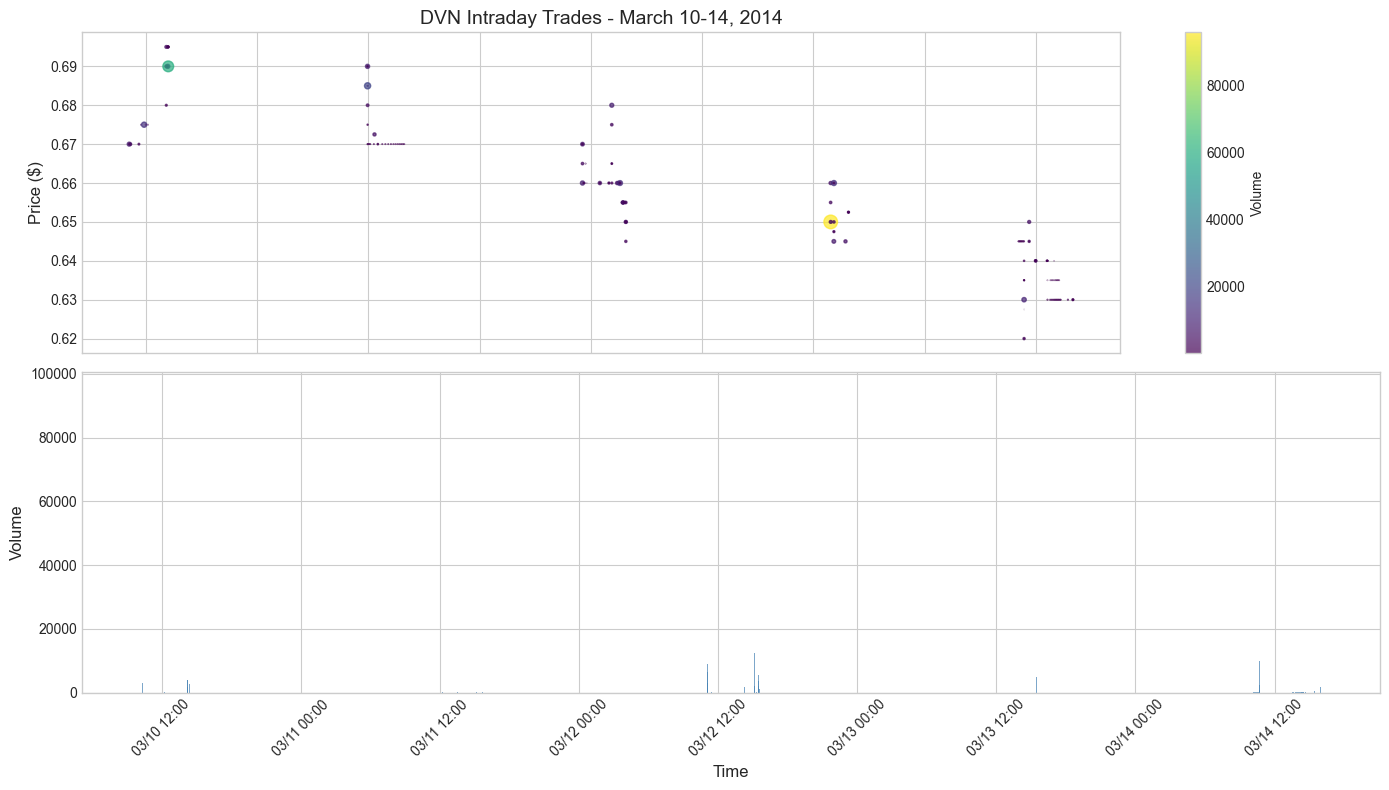

In [6]:
# Intraday price chart
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Price scatter plot
ax1 = axes[0]
scatter = ax1.scatter(
    df_dvn['Timestamp'],
    df_dvn['Price'],
    c=df_dvn['Volume'],
    cmap='viridis',
    alpha=0.7,
    s=df_dvn['Volume'] / 1000,  # Size by volume
)
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.set_title('DVN Intraday Trades - March 10-14, 2014', fontsize=14)
plt.colorbar(scatter, ax=ax1, label='Volume')

# Volume bar chart
ax2 = axes[1]
ax2.bar(
    df_dvn['Timestamp'],
    df_dvn['Volume'],
    width=0.001,
    color='steelblue',
    alpha=0.7,
)
ax2.set_ylabel('Volume', fontsize=12)
ax2.set_xlabel('Time', fontsize=12)

# Format x-axis
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# Daily OHLCV summary
daily_ohlcv = df_dvn.groupby('DateParsed').agg({
    'Price': ['first', 'max', 'min', 'last', 'mean'],
    'Volume': 'sum',
    'Timestamp': 'count',
}).round(2)

daily_ohlcv.columns = ['Open', 'High', 'Low', 'Close', 'VWAP', 'Volume', 'Trades']

# Calculate VWAP properly
for date in daily_ohlcv.index:
    day_data = df_dvn[df_dvn['DateParsed'] == date]
    vwap = (day_data['Price'] * day_data['Volume']).sum() / day_data['Volume'].sum()
    daily_ohlcv.loc[date, 'VWAP'] = round(vwap, 2)

print("=== Daily OHLCV Summary ===")
daily_ohlcv

=== Daily OHLCV Summary ===


,Open,High,Low,Close,VWAP,Volume,Trades
DateParsed,,,,,,,
2014-03-10,0.67,0.70,0.67,0.70,0.69,115325,19
2014-03-11,0.69,0.69,0.67,0.67,0.68,43336,43
2014-03-12,0.67,0.68,0.64,0.64,0.66,104227,40
2014-03-13,0.66,0.66,0.64,0.65,0.65,149041,17
2014-03-14,0.64,0.65,0.62,0.63,0.64,37168,113


## 5. Data Transformation for Ingestion

The sample data format differs from our Avro schema. We need to transform:
- Add `symbol` from company_id mapping
- Combine `Date` + `Time` → `exchange_timestamp`
- Generate `sequence_number` from row order

In [8]:
def transform_sample_trades(company_id: str, limit: int = None) -> pd.DataFrame:
    """Transform sample trade data to BatchLoader-compatible format."""
    csv_path = TRADES_DIR / f"{company_id}.csv"

    df = pd.read_csv(
        csv_path,
        names=["Date", "Time", "Price", "Volume", "Qualifiers", "Venue", "BuyerID"],
    )

    if limit:
        df = df.head(limit)

    company_info = COMPANY_MAPPING[company_id]

    # Transform to schema format
    result = pd.DataFrame({
        "symbol": company_info["symbol"],
        "company_id": int(company_id),
        "exchange": "ASX",
        "exchange_timestamp": df.apply(
            lambda row: parse_timestamp(row).isoformat(),
            axis=1,
        ),
        "price": df["Price"],
        "volume": df["Volume"],
        "qualifiers": df["Qualifiers"],
        "venue": df["Venue"].fillna("X"),
        "buyer_id": df["BuyerID"].fillna(""),
        "sequence_number": range(1, len(df) + 1),
    })

    return result

# Transform DVN data
df_transformed = transform_sample_trades("7181", limit=20)
print("Transformed data (first 10 rows):")
df_transformed.head(10)

Transformed data (first 10 rows):


,symbol,company_id,exchange,exchange_timestamp,price,volume,qualifiers,venue,buyer_id,sequence_number
0,DVN,7181,ASX,2014-03-10T10:13:34.553000,0.670,8216,0,X,,1
1,DVN,7181,ASX,2014-03-10T10:13:34.553000,0.670,784,2,X,,2
2,DVN,7181,ASX,2014-03-10T10:21:23.977000,0.670,3000,0,X,,3
3,DVN,7181,ASX,2014-03-10T11:16:11.355000,0.670,1469,0,X,,4
4,DVN,7181,ASX,2014-03-10T11:29:15.863000,0.675,120,0,X,,5
5,DVN,7181,ASX,2014-03-10T11:49:51.279000,0.675,14000,0,X,,6
6,DVN,7181,ASX,2014-03-10T12:00:08.830000,0.675,100,0,X,,7
7,DVN,7181,ASX,2014-03-10T12:15:08.408000,0.675,100,0,X,,8
8,DVN,7181,ASX,2014-03-10T14:13:19.874000,0.680,1827,0,X,,9
9,DVN,7181,ASX,2014-03-10T14:13:19.874000,0.690,4108,0,X,,10


In [9]:
# Schema validation
required_columns = [
    "symbol", "company_id", "exchange", "exchange_timestamp",
    "price", "volume", "qualifiers", "venue", "sequence_number",
]

print("Schema Validation:")
for col in required_columns:
    status = "" if col in df_transformed.columns else ""
    print(f"  {status} {col}: {df_transformed[col].dtype if col in df_transformed.columns else 'MISSING'}")

Schema Validation:
   symbol: object
   company_id: int64
   exchange: object
   exchange_timestamp: object
   price: float64
   volume: int64
   qualifiers: int64
   venue: object
   sequence_number: int64


## 6. Query Engine Demo

The K2 QueryEngine uses DuckDB with Iceberg extension to query market data.

**Note**: This requires Docker services to be running and data loaded into Iceberg.

In [10]:
# Try to import and connect to QueryEngine
try:
    from k2.query.engine import QueryEngine

    engine = QueryEngine()
    print("QueryEngine connected successfully!")

    # Get statistics
    stats = engine.get_stats()
    print("\nDatabase Statistics:")
    for key, value in stats.items():
        print(f"  {key}: {value}")

except Exception as e:
    print(f"QueryEngine not available: {e}")
    print("\nTo use QueryEngine, run:")
    print("  make docker-up")
    print("  make init-infra")
    engine = None

2026-01-11T12:21:31.391163+00:00 [INFO     ] Query engine initialized       component=query s3_endpoint=http://localhost:9000 warehouse_path=s3://warehouse/
QueryEngine connected successfully!

Database Statistics:
  s3_endpoint: http://localhost:9000
  warehouse_path: s3://warehouse/
  connection_active: True
  trades_count: 200753
  quotes_count: 4


In [11]:
# Query trades if engine is available
if engine:
    symbols = engine.get_symbols()
    print(f"Available symbols: {symbols}")

    if symbols:
        # Query first symbol
        symbol = symbols[0]
        print(f"\nQuerying trades for {symbol}...")

        trades = engine.query_trades(symbol=symbol, limit=10)
        print(f"Found {len(trades)} trades:")
        display(pd.DataFrame(trades))
else:
    print("Skipping query demo - QueryEngine not available")

Available symbols: ['BATCH', 'BHP', 'DVN', 'MWR', 'PREC', 'RIO', 'TEST']

Querying trades for BATCH...
Found 10 trades:


,symbol,company_id,exchange,exchange_timestamp,price,volume,qualifiers,venue,buyer_id,ingestion_timestamp,sequence_number
0,BATCH,9999,ASX,2014-03-10 10:00:59.059,100.59,1059,0,X,None,2026-01-11 10:38:42.688630,59
1,BATCH,9999,ASX,2014-03-10 10:00:59.059,100.59,1059,0,X,None,2026-01-10 16:02:27.724514,59
2,BATCH,9999,ASX,2014-03-10 10:00:58.058,100.58,1058,0,X,None,2026-01-10 16:02:27.724512,58
3,BATCH,9999,ASX,2014-03-10 10:00:58.058,100.58,1058,0,X,None,2026-01-11 10:38:42.688625,58
4,BATCH,9999,ASX,2014-03-10 10:00:57.057,100.57,1057,0,X,None,2026-01-10 16:02:27.724505,57
5,BATCH,9999,ASX,2014-03-10 10:00:57.057,100.57,1057,0,X,None,2026-01-11 10:38:42.688623,57
6,BATCH,9999,ASX,2014-03-10 10:00:56.056,100.56,1056,0,X,None,2026-01-11 10:38:42.688620,56
7,BATCH,9999,ASX,2014-03-10 10:00:56.056,100.56,1056,0,X,None,2026-01-10 16:02:27.724503,56
8,BATCH,9999,ASX,2014-03-10 10:00:55.055,100.55,1055,0,X,None,2026-01-11 10:38:42.688618,55
9,BATCH,9999,ASX,2014-03-10 10:00:55.055,100.55,1055,0,X,None,2026-01-10 16:02:27.724500,55


In [12]:
# Market summary example
if engine:
    symbols = engine.get_symbols()
    if symbols:
        symbol = symbols[0]
        # get_date_range returns the range for the entire table, not per-symbol
        date_range = engine.get_date_range()  # Don't pass symbol as table_name

        if date_range and date_range[0]:
            date = date_range[0].strftime('%Y-%m-%d')
            print(f"Market Summary for {symbol} on {date}:")

            summary = engine.get_market_summary(symbol, date_range[0].date())
            if summary:
                print(f"  Open:  ${summary.open_price:.2f}")
                print(f"  High:  ${summary.high_price:.2f}")
                print(f"  Low:   ${summary.low_price:.2f}")
                print(f"  Close: ${summary.close_price:.2f}")
                print(f"  Volume: {summary.volume:,}")
                print(f"  VWAP:  ${summary.vwap:.2f}")
            else:
                print("  No summary data available")
else:
    print("Skipping market summary - QueryEngine not available")

Market Summary for BATCH on 2014-03-10:
  Open:  $100.00
  High:  $100.99
  Low:   $100.00
  Close: $100.59
  Volume: 209,900
  VWAP:  $100.50


## 7. Time-Travel Demo

Apache Iceberg maintains a snapshot history of tables. This enables:
- Query historical data as it existed at any point
- Audit changes over time
- Rollback to previous states

In [13]:
# Try to import ReplayEngine
try:
    from k2.query.replay import ReplayEngine

    replay = ReplayEngine()
    print("ReplayEngine connected successfully!")

    # List snapshots - use table_name not table_type
    snapshots = replay.list_snapshots(table_name="trades", limit=5)
    print(f"\nFound {len(snapshots)} snapshots:")

    if snapshots:
        # SnapshotInfo returns objects, not dicts
        snapshot_data = []
        for snap in snapshots:
            snapshot_data.append({
                "snapshot_id": str(getattr(snap, "snapshot_id", "N/A"))[:16] + "...",
                "timestamp": str(getattr(snap, "timestamp", "N/A")),
                "added_records": getattr(snap, "added_records", 0) or 0,
            })
        df_snapshots = pd.DataFrame(snapshot_data)
        display(df_snapshots)
    else:
        print("No snapshots found (table may be empty)")

    replay.close()

except Exception as e:
    print(f"ReplayEngine not available: {e}")
    print("\nTime-travel requires Iceberg tables with data.")

2026-01-11T12:21:35.048489+00:00 [INFO     ] Query engine initialized       component=query s3_endpoint=http://localhost:9000 warehouse_path=s3://warehouse/
2026-01-11T12:21:35.923951+00:00 [INFO     ] Replay engine initialized      catalog_uri=http://localhost:8181 component=replay warehouse_path=s3://warehouse/
ReplayEngine connected successfully!

Found 5 snapshots:


,snapshot_id,timestamp,added_records
0,6158452215489857...,2026-01-11 22:14:38.281000,108671
1,4819083279315788...,2026-01-11 22:14:36.537000,232
2,3605929333729595...,2026-01-11 22:14:36.304000,91631
3,6348922622131450...,2026-01-11 22:14:33.908000,11
4,8151943497324609...,2026-01-11 10:38:43.039000,1


## 8. REST API Demo

The K2 API provides REST endpoints for querying market data.

**Base URL**: http://localhost:8000

**Endpoints**:
- `GET /health` - Health check
- `GET /v1/trades` - Query trades
- `GET /v1/quotes` - Query quotes
- `GET /v1/symbols` - List symbols
- `GET /v1/summary/{symbol}/{date}` - OHLCV summary

In [14]:
import requests

API_BASE = "http://localhost:8000"
API_KEY = "k2-dev-api-key-2026"
HEADERS = {"X-API-Key": API_KEY}

def api_get(endpoint, params=None, auth=True):
    """Make API GET request."""
    headers = HEADERS if auth else {}
    try:
        response = requests.get(f"{API_BASE}{endpoint}", headers=headers, params=params, timeout=5)
        return response.status_code, response.json()
    except requests.exceptions.ConnectionError:
        return None, {"error": "API not running. Start with: make api"}
    except Exception as e:
        return None, {"error": str(e)}

In [15]:
# Health check (no auth required)
status, data = api_get("/health", auth=False)
print(f"Health Check: {status}")
print(f"Response: {data}")

Health Check: 200
Response: {'status': 'healthy', 'version': '1.0.0', 'timestamp': '2026-01-11T12:21:38.381248', 'dependencies': [{'name': 'duckdb', 'status': 'healthy', 'latency_ms': 36.00573539733887, 'message': None}, {'name': 'iceberg', 'status': 'healthy', 'latency_ms': 459.61809158325195, 'message': None}]}


In [16]:
# Get trades (requires auth)
status, data = api_get("/v1/trades", params={"limit": 5})
print(f"Trades Endpoint: {status}")

if status == 200 and "data" in data:
    df_trades = pd.DataFrame(data["data"])
    display(df_trades)
else:
    print(f"Response: {data}")

Trades Endpoint: 200


,symbol,company_id,exchange,exchange_timestamp,price,volume,qualifiers,venue,buyer_id,ingestion_timestamp,sequence_number
0,RIO,7458,ASX,2014-03-14T17:06:06.940000,61.500,5572,3,X,None,2026-01-11T11:14:24.665593,108670
1,BHP,7078,ASX,2014-03-14T17:06:06.187000,35.660,119323,3,X,None,2026-01-11T11:14:24.665593,91630
2,BHP,7078,ASX,2014-03-14T16:23:56.646000,35.787,22142,3,X,None,2026-01-11T11:14:24.665593,91629
3,BHP,7078,ASX,2014-03-14T16:15:50.382000,35.787,19000,3,X,None,2026-01-11T11:14:24.665593,91628
4,BHP,7078,ASX,2014-03-14T16:15:16.022000,35.748,470000,3,X,None,2026-01-11T11:14:24.665593,91627


In [17]:
# List symbols
status, data = api_get("/v1/symbols")
print(f"Symbols Endpoint: {status}")

if status == 200 and "data" in data:
    print(f"Available symbols: {data['data']}")
else:
    print(f"Response: {data}")

Symbols Endpoint: 200
Available symbols: ['BATCH', 'BHP', 'DVN', 'MWR', 'PREC', 'RIO', 'TEST']


## 9. Summary

### What We Demonstrated

| Component | Description | Status |
|-----------|-------------|--------|
| Sample Data | Real ASX market data (March 2014) | Explored |
| Data Transformation | CSV → Avro schema format | Demonstrated |
| Visualization | Intraday charts, OHLCV | Created |
| Query Engine | DuckDB + Iceberg queries | Tested |
| Time-Travel | Iceberg snapshots | Explored |
| REST API | FastAPI endpoints | Tested |

### Key Commands

```bash
make docker-up      # Start all services
make init-infra     # Initialize Kafka topics and Iceberg tables
make api            # Start REST API server
k2-query --help     # Query CLI usage
```

### Links

- **API Docs**: http://localhost:8000/docs
- **Grafana**: http://localhost:3000 (admin/admin)
- **Kafka UI**: http://localhost:8080
- **MinIO Console**: http://localhost:9001

In [18]:
# Cleanup
if 'engine' in dir() and engine:
    engine.close()
    print("QueryEngine closed.")

print("\nDemo complete!")

QueryEngine closed.

Demo complete!
